In [32]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# normalize the image matrix
def toUINT(data):
    data-=data.min()
    data = 255.0*data/data.max()
    return data.astype(np.uint8)

# Convert RGB image to grayscale
def rgb2gray(img):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    if np.atleast_3d(img).shape[2] == 1:
        return toUINT(img)
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    gray = 0.2126*R + 0.7152*G + 0.0722*B
    return toUINT(gray)

def showPhoto(ph, size=(8,8)):
    plt.figure(figsize=size)
    plt.imshow(ph, cmap = 'gray', interpolation='none')
    plt.show()
    
# Otsu binarization 
def binarizer(img):
    ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

# BUG: symbol "-" is not processed correctly in case of small font sizes
def getSymbols(font, height, symbols=np.array(["@", "/", "\\", "0", "*", "|", "."], dtype=np.str)):
    font = ImageFont.truetype(font, height)
    bitmaps = {}
    
    for i in range(len(symbols)):
        img = Image.new(mode="L", size=(3*height, height), color=255)
        draw = ImageDraw.Draw(img)
        draw.text((0, 0), 2*symbols[i], font=font)
        buf_S = np.array(img)
        n = ((buf_S == 255*np.ones((height,1))).sum(axis=0) == height).argmin() + 1
        while not ( np.array_equal(buf_S[:,:n], buf_S[:,n:2*n]) and buf_S[:,2*n:].min()==255):
            n += 1
        bitmaps[symbols[i]] = buf_S[:,:n]
        
    return bitmaps

def getImage(pic, mode="grayscale"):
    img = Image.open(pic)
    img = np.array(img)
    
    if mode == "grayscale":
        return rgb2gray(img)
    elif mode == "binary":
        return binarizer(img)
    
def showSymbols(font, height, symbols, image_size, size=(8,8)):
    font = ImageFont.truetype(font, height)
    img = Image.new(mode="L", size=(image_size[1], len(symbols)*height), color=255)
    draw = ImageDraw.Draw(img)
    
    for i in range(len(symbols)):
        draw.text((0, height*i), "".join(symbols[i]), font=font)
        
    plt.figure(figsize=size)
    plt.imshow(img, cmap="gray")
    plt.show()

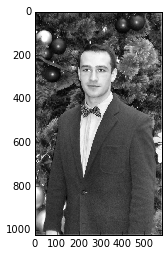

In [2]:
import scipy.misc

symbol_height = 10
alphabet = np.array(["@", "/", "\\", "0", "*", "|", ".", "7", "1", "3", "#", 'W', ',', '^', '\''])
symbols = getSymbols("arial.ttf", symbol_height, alphabet)
image = getImage("van9.jpg")
# image = getImage("12030eDrshxXOFCkMBPWi.jpg")
# image = scipy.misc.lena()
# image = getImage("penis.jpg")
# Image.open("ThresholdNoise_Lena30.png").show()

plt.imshow(image, cmap = 'gray', interpolation='none')
plt.show()

Cut the image to make its height to be divisible by symbols height. (**Useless in current implementation**)

In [3]:
rows_number = image.shape[0] / symbol_height
print image.shape
image = image[:rows_number*symbol_height, :]
print image.shape

(1024, 582)
(1020, 582)


In [4]:
cache = np.zeros((rows_number, image.shape[1]), int)
cache.fill(-1)
next_symbol = np.zeros((rows_number, image.shape[1] + 1), str)
next_symbol.fill('')
inf = sys.maxint


def loss(row, pos, symbol, ord=1):
    image_part = image[row * symbol_height : (row + 1) * symbol_height, pos : pos + symbol.shape[1]]
    if image_part.shape != symbol.shape:
        return inf
    return np.linalg.norm(symbol - image_part, ord=ord)

def dp(row, pos):
    if pos == image.shape[1]:
        return 0
    
    if pos > image.shape[1]:
        return inf
    
    if cache[row, pos] != -1:
        return cache[row, pos]
    
    res = inf
    
    for symbol_key, symbol in symbols.iteritems():
        next_pos = pos + symbol.shape[1]
        cur_res = dp(row, next_pos) + loss(row, pos, symbol)
        if cur_res < res:
            res = cur_res
            next_symbol[row, pos] = symbol_key
    cache[row, pos] = res
    return res

taken_symbols = []

for row in xrange(rows_number):
    dp(row, 0)
    cur_symbols = []
    pos = 0 
    while pos != image.shape[1]:
        cur_symbols.append(next_symbol[row, pos])
        pos += symbols[next_symbol[row, pos]].shape[1]
    taken_symbols.append(cur_symbols)

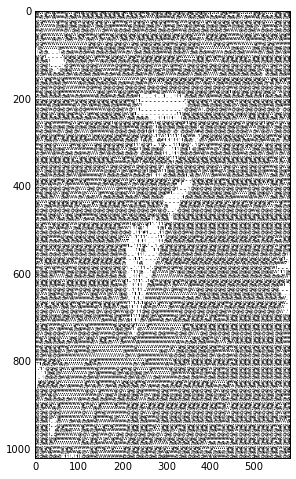

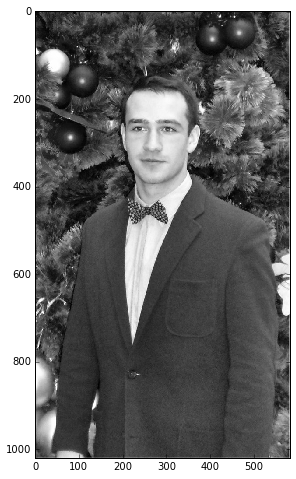

In [5]:
showSymbols("arial.ttf", symbol_height, taken_symbols, image.shape)
showPhoto(image)

In [3]:
from skimage import feature, filters, exposure
class LDDP(object):
    # Line Dependencies in Dynamic Programming
    #alphabet = np.array([".", "1", 'G', "m", "@", '^', ':', "*"], dtype=np.str)
    alphabet = np.array([".", "@", '1', '$', ':'], dtype=np.str)
    
    
    def __init__(self, image, font, height, alphabet=None):
        self.font = font
        self.image = rgb2gray(image)
        self.height = height
        if alphabet:
            self.alphabet = alphabet
        self.symbols = getSymbols(font, height, self.alphabet)

    
    def loss(self, source1, source2, ord=1):
        # Loss function
        #image_part = self.image[row * symbol_height : (row + 1) * symbol_height, pos : pos + symbol.shape[1]]
        if source1.shape != source2.shape:
            return sys.maxint
        return np.linalg.norm(source1 - source2, ord=ord)
    
    
    def dp(self, row, pos):
        if pos == self.image.shape[1]:
            return 0

        if pos > self.image.shape[1]:
            return sys.maxint

        if self.cache[row, pos] != -1:
            return self.cache[row, pos]

        res = sys.maxint
        for symbol_key, symbol in self.symbols.iteritems():
            next_pos = pos + symbol.shape[1]
            im_part = self.image[row * self.height : (row + 1) * self.height, pos : pos + symbol.shape[1]]
            line_part = self.line[:,pos : pos + symbol.shape[1]]
            cur_res = self.dp(row, next_pos) + self.loss(symbol, im_part, self.ord1)
            cur_res += self.C*self.loss(symbol, line_part, self.ord2)
            if cur_res < res:
                res = cur_res
                self.next_symbol[row, pos] = symbol_key
        self.cache[row, pos] = res
        return res
    
    def get_line(self, symbols):
        N = len(symbols)
        line = self.symbols[symbols[0]]
        for i in xrange(1,N):
            symb = self.symbols[symbols[i]]
            line = np.concatenate((line, symb), axis=1)
        return line[:,:self.image.shape[1]]
    
    
    def convert(self, ord1=1, ord2=1, C=0):
        # convertion
        # ord1: ord for norm in line
        # ord2: ord for norm between lines
        # return: string
        self.ord1 = ord1
        self.ord2 = ord2
        self.C = C
        cache = np.zeros((self.image.shape[0]/self.height, self.image.shape[1]), int)
        cache.fill(-1)
        self.cache = cache
        next_symbol = np.zeros((self.image.shape[0]/self.height, self.image.shape[1] + 1), str)
        next_symbol.fill('')
        self.next_symbol = next_symbol
        taken_symbols = []
        
        self.line = np.zeros((self.height, self.image.shape[1]))
        for row in xrange(self.image.shape[0]/self.height):
            self.dp(row, 0)
            cur_symbols = []
            pos = 0 
            while pos != self.image.shape[1]:
                cur_symbols.append(self.next_symbol[row, pos])
                pos += self.symbols[self.next_symbol[row, pos]].shape[1]
            self.line = self.get_line(cur_symbols)
            taken_symbols.append(cur_symbols)
            
        # get string
        S = ''
        for string in taken_symbols:
            N = len(string)
            for i in xrange(len(string)):
                symb = string[i]
                S += symb
            S += '\n'
        showSymbols(self.font, self.height, taken_symbols, self.image.shape, size=(6,6))#TODO: for testing. delete
        return S

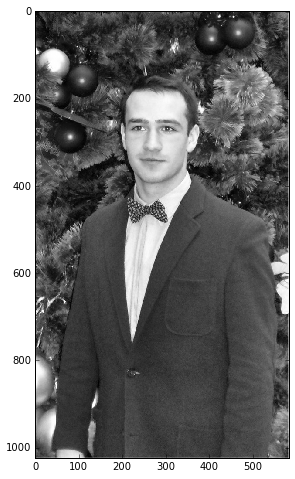

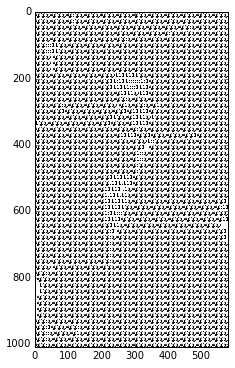

@@@@@@@:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@:@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@:@@@@@@@@@@@
@@@@@@@@@@@@@@@@@:@@@@@@@@@@@@@@@@@@@
@@:::11@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@:::11@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@:@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@1111111@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@11:111::::::1:1@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@111111:::1111@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@1111@111@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@:@@@@@@@@@@@@@@@@@@@
@@@@@:@@@@@@@@@@:@1@@@:@@1@@@@@@@@@@@@@
@@@@@1@@@@@@@@@@@1@11111@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@11@@@1111@1@@@@@@@@@@@@@@
1@@@@@@@@@@@@@1@@@@11111@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@:@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@11111@@1@@@@@@@@1@@@@@@
@@@@@@@@@@@@@@@@@@@@@1::@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@1::@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@1::@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@1::@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@

In [7]:
image = Image.open('van9.jpg')
image = rgb2gray(image)
image = filters.gaussian_filter(image, 2)
image = 1.-feature.canny(image)
image = filters.gaussian_filter(image,3)
showPhoto(image)
font = 'arial.ttf'
prob = LDDP(image, font, 18)
sym =  prob.convert(ord1=1, ord2='nuc', C=0.0)

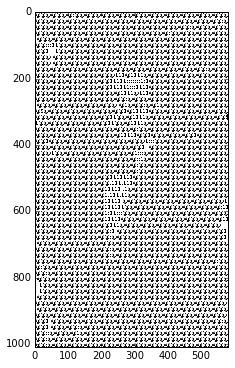

In [8]:
a = prob.convert(ord1=1, ord2='nuc', C=0.0)

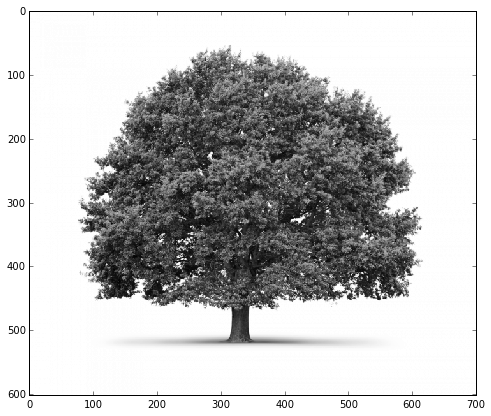

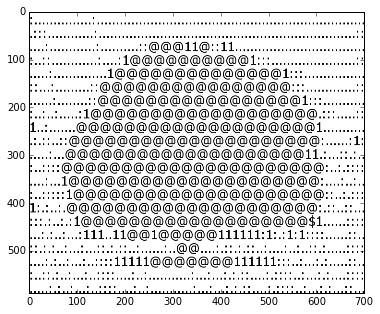

:...............:......................................................................
.:::............:...................................................................::
....:............:..........::@@@11@::11..................................
:..::............:....:1@@@@@@@@@@1:::......................::
.....:..............1@@@@@@@@@@@@@@1:::................
::...:.........::@@@@@@@@@@@@@@@@:::.............::
......:........::@@@@@@@@@@@@@@@@@1:::...........
:..:..:.....:1@@@@@@@@@@@@@@@@@@@.:::.....::
1..:.......@@@@@@@@@@@@@@@@@@@@1...........
.:.::..::@@@@@@@@@@@@@@@@@@@@@:......:1:
.....:...@@@@@@@@@@@@@@@@@@@@11.:...::.:..
:..::::@@@@@@@@@@@@@@@@@@@@@@:..:.::::
....:...1@@@@@@@@@@@@@@@@@@@@@:....:..:..
:..:::::1@@@@@@@@@@@@@@@@@@@@@::..:.:::
1:.:..:.@@@@@@@@@@@@@@@@@@@@@:.::..::...
:::.:..:.:1@@@@@@@@@@@@@@@@@@@$1......::::
...:.:..:...:111..11@@1@@@@@111111:1:.:1:1::::......::..
::.:.:..:...:...::.:.::..:......:..@@....:.::.:.::..:....:..:..::.:.....::::
....:.:..:...:..:

In [51]:
image = Image.open('tree.png')
image = rgb2gray(image)
# image = filters.gaussian_filter(image, 2)
# image = 1.-feature.canny(image)
# image = filters.gaussian_filter(image,3)
showPhoto(image)
font = 'vk.ttf'
prob = LDDP(image, font, 28)
print prob.convert(ord1=1, ord2='nuc', C=-0.04)

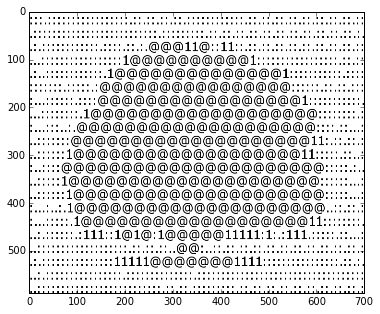

':::.:::::::::::::::::.::.::.::.::.::::::::::::.::.::.::.::.::.::.::.::.::\n.::::::::::::::::::::::::::.:::::::::.::.::.::.::.::.::.::.::.::.::.::.:.\n.:.::::::::::::.::::.::.:.@@@11@::11::.::.::.::.::.::.::.::.::.::\n...:::::::::::::::::1@@@@@@@@@@1:::::::::::::::::.::.::\n.:..::::::::::::.1@@@@@@@@@@@@@@1:::::::::::.::::\n:::::::.:::::.:@@@@@@@@@@@@@@@@::::::.::.::.:::\n:...::::::.::::@@@@@@@@@@@@@@@@@1:::::::::::.\n...::::::::.1@@@@@@@@@@@@@@@@@@@::::::::.:\n:...:::..:.@@@@@@@@@@@@@@@@@@@@::::.::...:\n..:::::::@@@@@@@@@@@@@@@@@@@@11:.::.::.:\n..::::::1@@@@@@@@@@@@@@@@@@@11:::::.::..:\n:..::::@@@@@@@@@@@@@@@@@@@@@@:::::.:..\n..:::::1@@@@@@@@@@@@@@@@@@@@@::::::...:\n..::::::1@@@@@@@@@@@@@@@@@@@@@:::::...:\n:...:..:.1@@@@@@@@@@@@@@@@@@@@@..::.::.:\n:...:::::.1@@@@@@@@@@@@@@@@@@@11::::::::.\n..:.::::::.:111::1@1@:1@@@@@11111:1:.:111.:::::.::...:\n..:::::::::::::::::::.::.::.::..@@:..::.::.::.::.::.::.::.::.::.::.::.:\n.:.:::::::::::::::11111@@@@@@@1111::::::::::::::::.::.:.\n..:.:::::::

In [10]:
prob.convert(ord1=1, ord2='nuc', C=0.0)

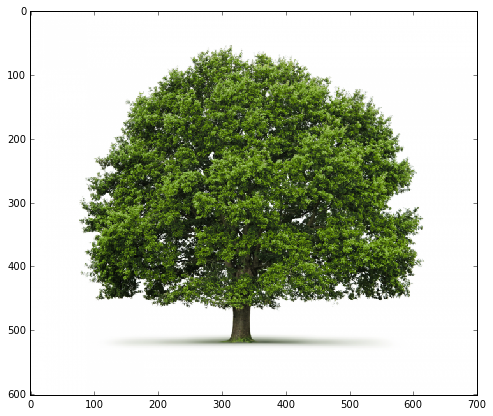

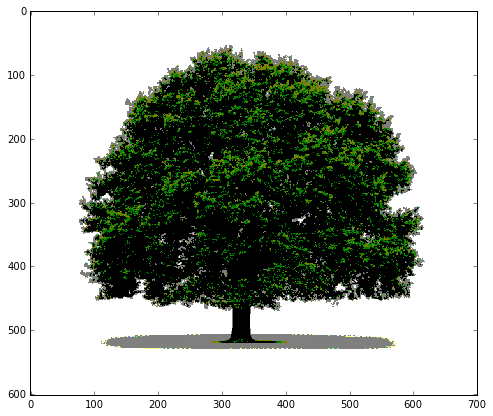

In [48]:
def ordered_dithering(image, nbit):
    def find_closest_pallet(color):
        def _floor(x, y):
            if x - x / y * y <= step / 2:
                return min(255, x / y * (y + 1))
            else:
                return min(255, x / y * y) 
        
        channel_num = 1
        if isinstance(color, np.ndarray):
            channel_num = len(color)

        step = channel_num * 255 / nbit
        if isinstance(color, np.ndarray):
            color = [_floor(int(x), step) for x in color]
        else:
            color = _floor(int(color), step)
        return color

    bayer8x8 = [
        [ 1, 49, 13, 61,  4, 52, 16, 64],
        [33, 17, 45, 29, 36, 20, 48, 32],
        [ 9, 57,  5, 53, 12, 60,  8, 56],
        [41, 25, 37, 21, 44, 28, 40, 24],
        [ 3, 51, 15, 63,  2, 50, 14, 62],
        [35, 19, 47, 31, 34, 18, 46, 30],
        [11, 59,  7, 55, 10, 58,  6, 54],
        [43, 27, 39, 23, 42, 26, 38, 22]
    ]

    new_image = image.copy()
    for x in xrange(new_image.shape[0]):
        for y in xrange(new_image.shape[1]):
            old_pixel = new_image[x][y] + new_image[x][y] * bayer8x8[x % 8][y % 8] * 1.0 / 65
            new_image[x][y] = find_closest_pallet(old_pixel)
    return new_image

tree = Image.open('tree.png')
tree = np.array(tree)
# tree = rgb2gray(tree)
showPhoto(tree)
tree_d = ordered_dithering(tree, 8)
showPhoto(tree_d)

In [80]:
class OpticalFlowDP(object):
    alphabet = np.array([".", "@", '1', '$', ':', '-', '*'], dtype=np.str)
    
    def __init__(self, image, font, height, alphabet=None):
        self.font = font
        self.image = rgb2gray(image)
        self.height = height
        if alphabet:
            self.alphabet = alphabet
        self.symbols = getSymbols(font, height, self.alphabet)

    
    def loss(self, source1, source2, ord=1):
        # Loss function
        #image_part = self.image[row * symbol_height : (row + 1) * symbol_height, pos : pos + symbol.shape[1]]
        if source1.shape != source2.shape:
            return sys.maxint
        return np.linalg.norm(source1 - source2, ord=ord)
    
    
    def dp(self, row, pos):
        if pos == self.image.shape[1]:
            return 0

        if pos > self.image.shape[1]:
            return sys.maxint

        if self.cache[row, pos] != -1:
            return self.cache[row, pos]

        res = sys.maxint
        for symbol_key, symbol in self.symbols.iteritems():
            next_pos = pos + symbol.shape[1]
            im_part = self.image[row * self.height : (row + 1) * self.height, pos : pos + symbol.shape[1]]
            line_part = self.line[:,pos : pos + symbol.shape[1]]
            cur_res = self.dp(row, next_pos) + self.loss(symbol, im_part, self.ord1)
            cur_res += self.C*self.loss(symbol, line_part, self.ord2)
            if cur_res < res:
                res = cur_res
                self.next_symbol[row, pos] = symbol_key
        self.cache[row, pos] = res
        return res
    
    def get_line(self, symbols):
        N = len(symbols)
        line = self.symbols[symbols[0]]
        for i in xrange(1,N):
            symb = self.symbols[symbols[i]]
            line = np.concatenate((line, symb), axis=1)
        return line[:,:self.image.shape[1]]
    
    
    def convert(self, ord1=1, ord2=1, C=0):
        # convertion
        # ord1: ord for norm in line
        # ord2: ord for norm between lines
        # return: string
        self.ord1 = ord1
        self.ord2 = ord2
        self.C = C
        cache = np.zeros((self.image.shape[0]/self.height, self.image.shape[1]), int)
        cache.fill(-1)
        self.cache = cache
        next_symbol = np.zeros((self.image.shape[0]/self.height, self.image.shape[1] + 1), str)
        next_symbol.fill('')
        self.next_symbol = next_symbol
        taken_symbols = []
        
        self.line = np.zeros((self.height, self.image.shape[1]))
        for row in xrange(self.image.shape[0]/self.height):
            self.dp(row, 0)
            cur_symbols = []
            pos = 0 
            while pos != self.image.shape[1]:
                cur_symbols.append(self.next_symbol[row, pos])
                pos += self.symbols[self.next_symbol[row, pos]].shape[1]
            self.line = self.get_line(cur_symbols)
            taken_symbols.append(cur_symbols)
            
        # get string
        S = ''
        for string in taken_symbols:
            N = len(string)
            for i in xrange(len(string)):
                symb = string[i]
                S += symb
            S += '\n'
        showSymbols(self.font, self.height, taken_symbols, self.image.shape, size=(12,8))#TODO: for testing. delete
        return S

In [61]:

image = Image.open('tree.png')
image = rgb2gray(image)
image = filters.gaussian_filter(image, 2)
image = 1.-feature.canny(image)
image = filters.gaussian_filter(image,2)
image = toUINT(image)
image = binarizer(image) 
edges = image

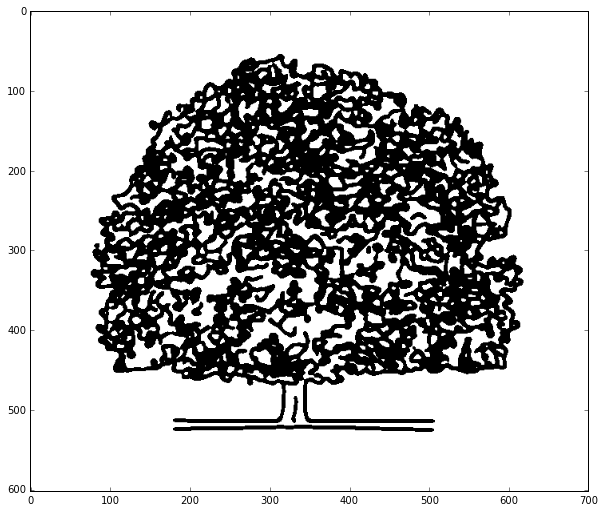

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
#plt.savefig('edges.png')

In [53]:
image = Image.open('peppa.png')
rgb = np.array(image)
image = rgb2gray(image)
di = ordered_dithering(rgb, 8)

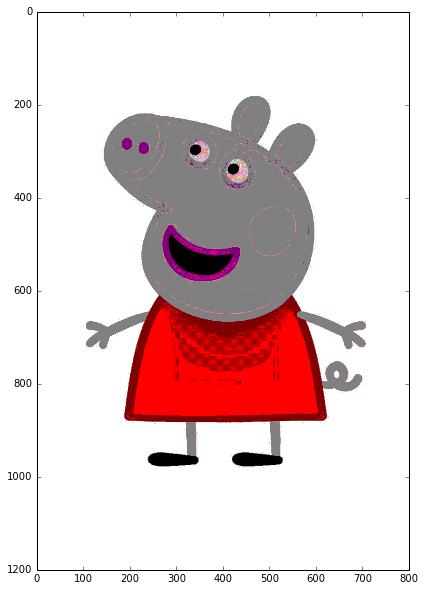

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(di)
plt.savefig('dithering.png')

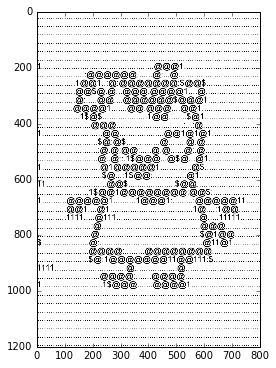

In [82]:
image = Image.open('peppa.png')
image = rgb2gray(image)
image = filters.gaussian_filter(image, 2)
image = 1.-feature.canny(image)
image = filters.gaussian_filter(image,2)
image = toUINT(image)
image = binarizer(image) 
font = 'arial.ttf'
prob = LDDP(image, font, 30)
sym =  prob.convert(ord1=1, ord2='nuc', C=0.0)

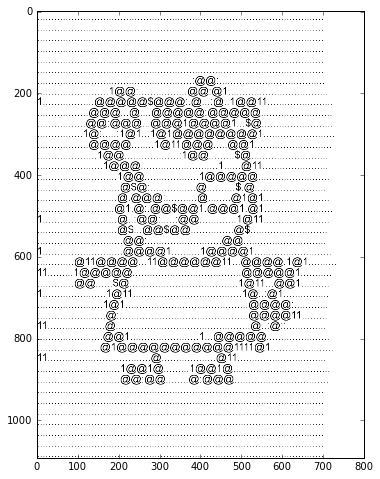

In [73]:
showSymbols(font, 26,sym.split(), image.shape)